### 50. データの入手・整形

zipファイルからデーターセットを読み込む

In [1]:
import zipfile

In [2]:
# zipファイルから読み込む
with zipfile.ZipFile('data/NewsAggregatorDataset.zip') as f:
    with f.open('newsCorpora.csv') as g:
        data = g.read()

# バイト列をデコード
data = data.decode('UTF-8').splitlines()

# タブ区切り
data = [line.split('\t') for line in data]
len(data)

422937

情報源を指定・ランダムに並び替える

In [3]:
publishers = {
    'Reuters',
    'Huffington Post',
    'Businessweek',
    'Contactmusic.com',
    'Daily Mail'}
data = [
    lst
    for lst in data
    if lst[3] in publishers]
data.sort()
len(data)

13356

カテゴリ名と記事見出しのみ

In [4]:
data = [
    [lst[4], lst[1]]
    for lst in data]

学習・検証・評価データに分割

In [5]:
train_end = int(len(data) * 0.8)
valid_end = int(len(data) * 0.9)
train = data[:train_end]
valid = data[train_end:valid_end]
test = data[valid_end:]
print('学習データ', len(train))
print('検証データ', len(valid))
print('評価データ', len(test))

学習データ 10684
検証データ 1336
評価データ 1336


ファイルに保存

In [6]:
def write_dataset(filename, data):
    with open(filename, 'w') as f:
        for lst in data:
            print('\t'.join(lst), file = f)

In [7]:
write_dataset('data/train.txt', train)
write_dataset('data/valid.txt', valid)
write_dataset('data/test.txt', test)

事例数を確認

In [8]:
from collections import Counter
from tabulate import tabulate

In [9]:
categories = ['b', 't', 'e', 'm']
category_names = ['business', 'science and technology', 'entertainment', 'health']
table = [
    [name] + [freqs[cat] for cat in categories]
    for name, freqs in [
        ('train', Counter([cat for cat, _ in train])),
        ('valid', Counter([cat for cat, _ in valid])),
        ('test', Counter([cat for cat, _ in test])),
    ]
]
tabulate(table, tablefmt = 'html', headers = categories)

,b,t,e,m
train,4463,1223,4277,721
valid,617,168,459,92
test,547,134,558,97


### 51. 特徴量抽出

tf-idfとか単語ベクトルとかに手を出したら闇が深いので，Bag-of-Words(lemmas?)で手を打つ

In [10]:
# ! pip install nltk

In [11]:
# ! python -m spacy download en

In [12]:
import re
import spacy
import nltk

単語列に分割し，小文字化と語幹化

In [13]:
nlp = spacy.load('en')
stemmer = nltk.stem.snowball.SnowballStemmer(language='english')

def tokenize(x):
    x = re.sub(r'\s+', ' ', x)
    x = nlp.make_doc(x) # nlp(x)は遅い tokenizer以外も走るので
    x = [stemmer.stem(doc.lemma_.lower()) for doc in x]
    return x

In [14]:
tokenized_train = [[cat, tokenize(line)] for cat, line in train]
tokenized_valid = [[cat, tokenize(line)] for cat, line in valid]
tokenized_test = [[cat, tokenize(line)] for cat, line in test]

特徴量として使うトークンを抽出

In [15]:
# 出現頻度を数える
counter = Counter([
    token
    for _, tokens in tokenized_train
    for token in tokens])

# 高頻度・低頻度の語を取り除く
vocab = [
    token
    for token, freq in counter.most_common()
    if 2 < freq < 300]

len(vocab)

4790

bi-gramも特徴量とする

In [16]:
bi_grams = Counter([
        bi_gram
        for _, sent in tokenized_train
        for bi_gram in zip(sent, sent[1:])
    ]).most_common()
bi_grams = [tup for tup, freq in bi_grams if freq > 4]
len(bi_grams)

3093

保存しておく

In [17]:
with open('result/vocab_for_news.txt', 'w') as f:
    for token in vocab:
        print(token, file = f)

In [18]:
with open('result/bi_grams_for_news.txt', 'w') as f:
    for tup in bi_grams:
        print(' '.join(tup), file = f)

全特徴量

In [19]:
features = vocab + [' '.join(x) for x in bi_grams]
len(features)

7883

特徴量を抽出しデータを保存

In [20]:
import numpy as np

In [21]:
vocab_dict = {x:n for n, x in enumerate(vocab)}
bi_gram_dict = {x:n for n, x in enumerate(bi_grams)}

def count_uni_gram(sent):
    lst = [0 for token in vocab]
    for token in sent:
        if token in vocab_dict:
            lst[vocab_dict[token]] += 1
    return lst

def count_bi_gram(sent):
    lst = [0 for token in bi_grams]
    for tup in zip(sent, sent[1:]):
        if tup in bi_gram_dict:
            lst[bi_gram_dict[tup]] += 1
    return lst

In [22]:
def prepare_feature_dataset(data):
    ts = [categories.index(cat) for cat, _ in data]
    xs = [
        count_uni_gram(sent) + count_bi_gram(sent)
        for _, sent in data
    ]
    return np.array(xs, dtype=np.float32), np.array(ts, dtype=np.int8)

def write_feature_dataset(filename, xs, ts):
    with open(filename, 'w') as f:
        for t, x in zip(ts, xs):
            line = categories[t] + ' ' + ' '.join([str(int(n)) for n in x])
            print(line, file = f)    

In [23]:
train_x, train_t = prepare_feature_dataset(tokenized_train)
valid_x, valid_t = prepare_feature_dataset(tokenized_valid)
test_x, test_t = prepare_feature_dataset(tokenized_test)

In [24]:
write_feature_dataset('result/train.feature.txt', train_x, train_t)
write_feature_dataset('result/valid.feature.txt', valid_x, valid_t)
write_feature_dataset('result/test.feature.txt', test_x, test_t)

例

In [25]:
import pandas as pd

In [26]:
with open('result/train.feature.txt') as f:
    table = [line.strip().split(' ') for _, line in zip(range(10), f)]
pd.DataFrame(table, columns=['category'] + features)

,category,rise,;,it,kim,will,over,china,high,share,...,still miss,simpson have,wireless festiv,black widow,jk rowl,for busi,with alibaba,nadin gordim,peter jackson,allison william
0,m,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,m,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,m,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,t,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,m,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,t,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,m,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,t,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,m,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,m,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 52. 学習

sklearnを使います

In [27]:
# ! pip install sklearn

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
lr = LogisticRegression(max_iter=1000)
lr.fit(train_x, train_t)

LogisticRegression(max_iter=1000)

### 53. 予測

In [30]:
def predict(x):
    out = lr.predict_proba(x)
    preds = out.argmax(axis=1)
    probs = out.max(axis=1)
    return preds, probs

In [31]:
preds, probs = predict(train_x)
pd.DataFrame([[y, p] for y, p in zip(preds, probs)], columns = ['予測', '確率'])

,予測,確率
0,0,0.296438
1,3,0.582262
2,3,0.400619
3,1,0.686065
4,3,0.845692
...,...,...
10679,3,0.702896
10680,3,0.906331
10681,3,0.680921
10682,3,0.997405


In [32]:
preds, probs = predict(test_x)
pd.DataFrame([[y, p] for y, p in zip(preds, probs)], columns = ['予測', '確率'])

,予測,確率
0,2,0.976047
1,2,0.989112
2,2,0.985547
3,2,0.784794
4,2,0.999377
...,...,...
1331,1,0.974074
1332,2,0.671835
1333,2,0.881669
1334,2,0.889977


### 54. 正解率の計測

In [33]:
def accuracy(lr, xs, ts):
    ys = lr.predict(xs)
    return (ys == ts).mean()

In [34]:
print('訓練データ')
print(accuracy(lr, train_x, train_t))

訓練データ
0.994664919505803


In [35]:
print('評価データ')
print(accuracy(lr, test_x, test_t))

評価データ
0.906437125748503


### 55. 混同行列の作成

In [36]:
! pip install seaborn

In [37]:
import seaborn as sns

In [38]:
def confusion_matrix(xs, ts):
    num_class = np.unique(ts).size
    mat = np.zeros((num_class, num_class), dtype=np.int32)
    ys = lr.predict(xs)
    for y, t in zip(ys, ts):
        mat[t, y] += 1
    return mat

def show_cm(cm):
    sns.heatmap(cm, annot=True, cmap = 'Blues', xticklabels = categories, yticklabels = categories)

訓練データ
[[4451   10    2    0]
 [  25 1192    6    0]
 [   4    1 4271    1]
 [   5    0    3  713]]


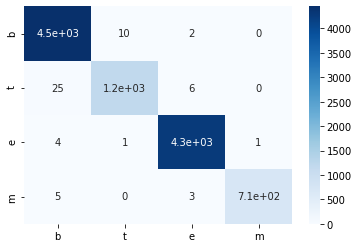

In [39]:
train_cm = confusion_matrix(train_x, train_t)
print('訓練データ')
print(train_cm)
show_cm(train_cm)

評価データ
[[516  13  12   6]
 [ 35  87  10   2]
 [ 22   2 531   3]
 [ 10   5   5  77]]


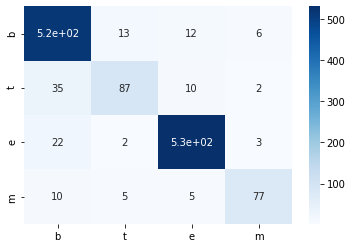

In [40]:
test_cm = confusion_matrix(test_x, test_t)
print('評価データ')
print(test_cm)
show_cm(test_cm)

### 56. 適合率，再現率，F1スコアの計測

In [41]:
tp = test_cm.diagonal()
tn = test_cm.sum(axis=1) - tp
fp = test_cm.sum(axis=0) - tp

In [42]:
p = tp / (tp + tn)
r = tp / (tp + fp)
F = 2 * p * r / (p + r)

In [43]:
micro_p = tp.sum() / (tp + tn).sum()
micro_r = tp.sum() / (tp + fp).sum()
micro_F = 2 * micro_p * micro_r / (micro_p + micro_r)
micro_ave = np.array([micro_p, micro_r, micro_F])

In [44]:
macro_p = p.mean()
macro_r = r.mean()
macro_F = 2 * macro_p * macro_r / (macro_p + macro_r)
macro_ave = np.array([macro_p, macro_r, macro_F])

In [45]:
table = np.array([p, r, F]).T
table = np.vstack([table, micro_ave, macro_ave])
pd.DataFrame(
    table,
    index = categories + ['マイクロ平均'] + ['マクロ平均'],
    columns = ['再現率', '適合率', 'F1スコア'])

,再現率,適合率,F1スコア
b,0.943327,0.885077,0.913274
t,0.649254,0.813084,0.721992
e,0.951613,0.951613,0.951613
m,0.793814,0.875000,0.832432
マイクロ平均,0.906437,0.906437,0.906437
マクロ平均,0.834502,0.881194,0.857212


### 57. 特徴量の重みの確認

In [46]:
def show_weight(directional, N):
    for i, cat in enumerate(categories):
        indices = lr.coef_[i].argsort()[::directional][:N]
        best = np.array(features)[indices]
        weight = lr.coef_[i][indices]
        print(category_names[i])
        display(pd.DataFrame([best, weight], index = ['特徴量', '重み'], columns = np.arange(N) + 1))

重みの高い特徴量トップ10

In [47]:
show_weight(-1, 10)

business


,1,2,3,4,5,6,7,8,9,10
特徴量,bank,fed,ukrain,yellen,china,ecb,fund,bond,profit,obamacar
重み,1.737694,1.621557,1.590027,1.516143,1.44646,1.424372,1.422939,1.355499,1.327574,1.319162


science and technology


,1,2,3,4,5,6,7,8,9,10
特徴量,facebook,googl,climat,appl,microsoft,nasa,fcc,activis,heartble,moon
重み,2.713217,2.678776,2.307383,2.239935,2.173845,1.792391,1.72837,1.677206,1.653214,1.527023


entertainment


,1,2,3,4,5,6,7,8,9,10
特徴量,kim,film,movi,chris,wed,fan,star,kim kardashian,transform,easter
重み,1.501871,1.479709,1.358865,1.287822,1.285315,1.245823,1.174278,1.165308,1.159209,1.1541


health


,1,2,3,4,5,6,7,8,9,10
特徴量,fda,cancer,mer,brain,ebola,doctor,studi,drug,medic,cdc
重み,1.944553,1.745326,1.735664,1.732229,1.652991,1.651165,1.603814,1.594485,1.559485,1.49148


重みの低い特徴量トップ10

In [48]:
show_weight(1, 10)

business


,1,2,3,4,5,6,7,8,9,10
特徴量,aereo,activis,babi,subscript,star,hat,victim,gentiva,virus,the ...
重み,-1.467555,-1.456679,-1.147261,-1.086733,-1.005208,-1.002755,-0.996982,-0.992283,-0.957664,-0.956185


science and technology


,1,2,3,4,5,6,7,8,9,10
特徴量,percent,drug,40,us stock,cancer,in ...,her,face,fed,well
重み,-0.943532,-0.896814,-0.880377,-0.81121,-0.810557,-0.804296,-0.781115,-0.764879,-0.763376,-0.751787


entertainment


,1,2,3,4,5,6,7,8,9,10
特徴量,googl,china,facebook,recal,rule,oil,price,studi,scientist,microsoft
重み,-1.426515,-1.300854,-1.187751,-1.12225,-1.079243,-1.043356,-1.038875,-1.026172,-0.982693,-0.953479


health


,1,2,3,4,5,6,7,8,9,10
特徴量,dimon,deal,facebook,ceo,gm,fund,climat,appl,hit,twitter
重み,-0.889596,-0.776381,-0.76598,-0.76043,-0.748355,-0.723142,-0.712365,-0.680767,-0.621883,-0.597171


### 58. 正則化パラメータの変更

In [49]:
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm

In [50]:
Cs = np.arange(0.1, 5.1, 0.5)
lrs = [LogisticRegression(C=C, max_iter=1000).fit(train_x, train_t) for C in tqdm(Cs)]

100%|██████████| 10/10 [02:39<00:00, 15.98s/it]


In [51]:
train_accs = [accuracy(lr, train_x, train_t) for lr in lrs]
valid_accs = [accuracy(lr, valid_x, valid_t) for lr in lrs]
test_accs = [accuracy(lr, test_x, test_t) for lr in lrs]

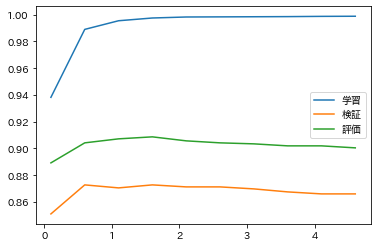

In [52]:
plt.plot(Cs, train_accs, label = '学習')
plt.plot(Cs, valid_accs, label = '検証')
plt.plot(Cs, test_accs, label = '評価')
plt.legend()
plt.savefig('result/58.png')

正則化が弱いと過学習してるのがわかる

### 59. ハイパーパラメータの探索

打ち切り誤差を変えて見る

In [53]:
tols = np.logspace(0, 2, 10)
lrs = [LogisticRegression(tol=tol, max_iter=1000).fit(train_x, train_t) for tol in tqdm(tols)]

100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


In [54]:
train_accs = [accuracy(lr, train_x, train_t) for lr in lrs]
valid_accs = [accuracy(lr, valid_x, valid_t) for lr in lrs]
test_accs = [accuracy(lr, test_x, test_t) for lr in lrs]

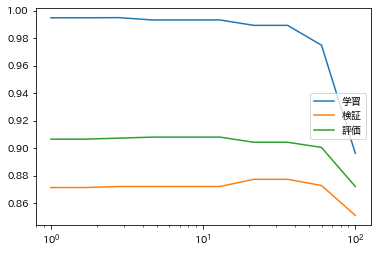

In [55]:
plt.plot(tols, train_accs, label = '学習')
plt.plot(tols, valid_accs, label = '検証')
plt.plot(tols, test_accs, label = '評価')
plt.xscale('log')
plt.legend()
plt.savefig('result/59.png')

sklearnの有名なフローチャートを見てなにかないかなという気持ちをする

<img src='https://scikit-learn.org/stable/_static/ml_map.png'>

ナイーブベイズ

In [56]:
from sklearn.naive_bayes import MultinomialNB

In [57]:
nb = MultinomialNB()
nb.fit(train_x, train_t)

MultinomialNB()

In [58]:
accuracy(nb, train_x, train_t)

0.9429988768251591

In [59]:
accuracy(nb, test_x, test_t)

0.8907185628742516

サポートベクトルマシン

In [60]:
from sklearn.svm import LinearSVC

In [61]:
svc = LinearSVC(C=0.1)
svc.fit(train_x,train_t)

LinearSVC(C=0.1)

In [62]:
accuracy(svc, train_x, train_t)

0.9908274054661176

In [63]:
accuracy(svc, test_x, test_t)

0.9041916167664671